In [1]:
import pandas as pd
import numpy as np
import re
import nltk

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud

import keras
from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

from sklearn.metrics import classification_report,confusion_matrix

In [2]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

## Análise exploratória dos dados

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
train[['id', 'keyword', 'location', 'text']].isnull().sum()

id             0
keyword       61
location    2533
text           0
dtype: int64

In [6]:
train['text'].describe()

count                                                  7613
unique                                                 7503
top       11-Year-Old Boy Charged With Manslaughter of T...
freq                                                     10
Name: text, dtype: object

# Visualizando alguns gráficos

In [7]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [8]:
train["target"].value_counts().iplot(kind='bar',text=['Fake', 'Real'], title='Comparando os tweets se são sobre desastres (1) ou não (0)',color=['blue'])

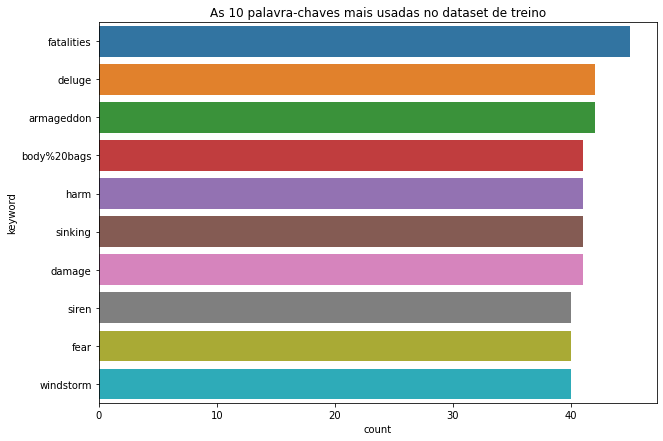

In [9]:
plt.figure(figsize= (10,7))
sns.countplot(y= train['keyword'], order=train['keyword'].value_counts().iloc[:10].index)
plt.title('As 10 palavra-chaves mais usadas no dataset de treino')
plt.show()

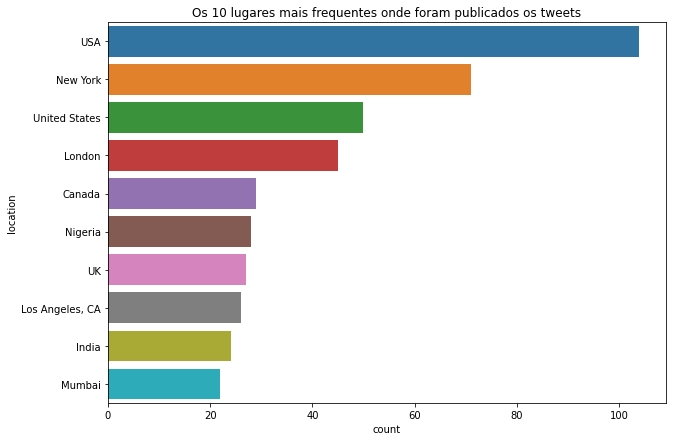

In [10]:
plt.figure(figsize= (10,7))
sns.countplot(y= train['location'], order=train['location'].value_counts().iloc[:10].index)
plt.title('Os 10 lugares mais frequentes onde foram publicados os tweets')
plt.show()

# Pré-processamento dos dados

## Excluindo as colunas que não vamos trabalhar

In [11]:
train = train.drop(['keyword', 'location', 'id'], axis=1)

#test
test = test.drop(['keyword', 'location', 'id'], axis=1)

## Removendo as Stopwords

In [12]:
def RemoveStopWords(text):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    words = [i for i in text.split() if not i in stopwords]
    return (" ".join(words))

In [13]:
train['text'] = [RemoveStopWords(i) for i in train['text']]

# test
test['text'] = [RemoveStopWords(i) for i in test['text']]

train['text'][:10]

0    Our Deeds Reason #earthquake May ALLAH Forgive us
1               Forest fire near La Ronge Sask. Canada
2    All residents asked 'shelter place' notified o...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent photo Ruby #Alaska smoke #wildfi...
5    #RockyFire Update => California Hwy. 20 closed...
6    #flood #disaster Heavy rain causes flash flood...
7                     I'm top hill I see fire woods...
8    There's emergency evacuation happening buildin...
9                    I'm afraid tornado coming area...
Name: text, dtype: object

## Removendo os caracteres especiais

In [14]:
def Remove_carac(text):
    text = text.str.lower() 
    text = text.str.replace(r"\#","") 
    text = text.str.replace(r"http\S+","")  
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^a-zA-Z#]", " ")
    text = text.str.replace("\s{2,}", "")
    return text

In [15]:
train['clean_text'] = Remove_carac(train['text'])

#test
test['clean_text'] = Remove_carac(test['text'])

train['clean_text'][:10]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

The default value of regex will change from True to False in a future version.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

The default value of regex will change from True to False in a future version.



0     our deeds reason earthquake may allah forgive us
1                 forest fire near la ronge saskcanada
2    all residents askedshelter placenotified offic...
3    people receive wildfires evacuation orders cal...
4    just got sent photo ruby alaska smoke wildfire...
5    rockyfire updatecalifornia hwyclosed direction...
6    flood disaster heavy rain causes flash floodin...
7                        i m top hill i see fire woods
8    there s emergency evacuation happening buildin...
9                       i m afraid tornado coming area
Name: clean_text, dtype: object

## Lemmatization

In [16]:
lem = WordNetLemmatizer()

def Lemmatization(text):
    words = []
    for w in text.split():
        words.append(lem.lemmatize(w))
    return (" ".join(words))

In [17]:
train['clean_text'] = [Lemmatization(f) for f in train['clean_text']]

#test
test['clean_text'] = [Lemmatization(f) for f in test['clean_text']]

train['clean_text'][:10]

0       our deed reason earthquake may allah forgive u
1                 forest fire near la ronge saskcanada
2    all resident askedshelter placenotified office...
3    people receive wildfire evacuation order calif...
4    just got sent photo ruby alaska smoke wildfire...
5    rockyfire updatecalifornia hwyclosed direction...
6    flood disaster heavy rain cause flash flooding...
7                         i m top hill i see fire wood
8    there s emergency evacuation happening buildin...
9                       i m afraid tornado coming area
Name: clean_text, dtype: object

## Stemming

In [18]:
def Stemming(text):
    stemmer = SnowballStemmer(language='english')
    words = []
    for w in text.split():
        words.append(stemmer.stem(w))
    return (" ".join(words))

In [19]:
train['clean_text'] = [Stemming(t) for t in train['clean_text']]

#test
test['clean_text'] = [Stemming(t) for t in test['clean_text']]

train['clean_text'][:10]

0         our deed reason earthquak may allah forgiv u
1                  forest fire near la rong saskcanada
2    all resid askedshelt placenotifi officersno ev...
3          peopl receiv wildfir evacu order california
4    just got sent photo rubi alaska smoke wildfir ...
5    rockyfir updatecalifornia hwyclos direct due l...
6    flood disast heavi rain caus flash flood stree...
7                         i m top hill i see fire wood
8       there s emerg evacu happen build across street
9                         i m afraid tornado come area
Name: clean_text, dtype: object

In [20]:
# excluindo a coluna text e reorganizando as colunas
train = train.drop(['text'], axis=1)
train = train.reindex(columns=['clean_text', 'target'])

#test
test = test.drop(['text'], axis=1)
test = test.reindex(columns=['clean_text', 'target'])

train.head()

,clean_text,target
0,our deed reason earthquak may allah forgiv u,1
1,forest fire near la rong saskcanada,1
2,all resid askedshelt placenotifi officersno ev...,1
3,peopl receiv wildfir evacu order california,1
4,just got sent photo rubi alaska smoke wildfir ...,1


## Dando uma olhada nas palavras mais frequentes com WordCloud

In [21]:
# unindo treino e teste
df = pd.concat([train,test], ignore_index=True)

In [22]:
# excluindo palavras com menos de 3 letras para melhor entendimento do gráfico
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df.head()

,clean_text,target
0,deed reason earthquak allah forgiv,1.0
1,forest fire near rong saskcanada,1.0
2,resid askedshelt placenotifi officersno evacu ...,1.0
3,peopl receiv wildfir evacu order california,1.0
4,just sent photo rubi alaska smoke wildfir pour...,1.0


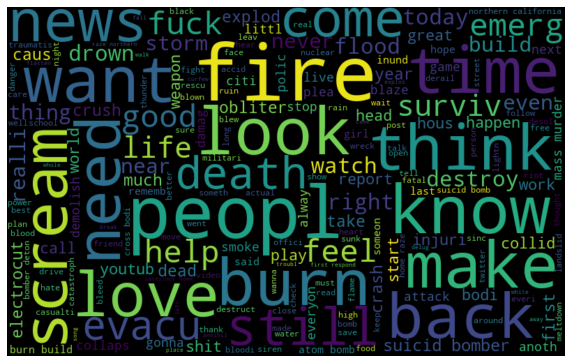

In [23]:
# usando o WordCloud para visualizar as palavras que aparecem com frequencia
words = ' '.join([text for text in df['clean_text']])

wordcloud = WordCloud(width=800, height = 500, max_font_size=110).generate(words)

# plotando
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [24]:
from collections import Counter

# quantas palavras unicas tem no texto
def counter_word (text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [25]:
text_values = train["clean_text"]

counter = counter_word(text_values)

In [26]:
print(f"The len of unique words is: {len(counter)}")
list(counter.items())[:10]

The len of unique words is: 17864


[('our', 18),
 ('deed', 1),
 ('reason', 25),
 ('earthquak', 29),
 ('may', 80),
 ('allah', 8),
 ('forgiv', 1),
 ('u', 215),
 ('forest', 47),
 ('fire', 279)]

In [27]:
# o número máximo de palavras usadas

vocab_size = len(counter)
embedding_dim = 32
max_length = 20
trunc_type='post'
padding_type='post'
oov_tok = "<XXX>"
training_size = 3807
seq_len = 12

## Train test split

In [28]:
X = train['clean_text']
y = train['target']

In [29]:
from sklearn.model_selection import train_test_split
np.random.seed(42)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.5, random_state=42)

In [30]:
from sklearn.model_selection import RepeatedKFold
kf = RepeatedKFold(n_splits= 2, n_repeats=10, random_state=42)

for train_lines, valid_lines in kf.split(X):
    X_train, X_valid = X.iloc[train_lines], X.iloc[valid_lines]
    y_train, y_valid = y.iloc[train_lines], y.iloc[valid_lines]

In [31]:
print('The Shape of training ',X_train.shape)
print('The Shape of testing',X_valid.shape)

The Shape of training  (3807,)
The Shape of testing (3806,)


## Tokenization

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [33]:
oov_tok = "<XXX>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [34]:
word_index = tokenizer.word_index

In [35]:
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [36]:
print(train.clean_text[1])
print(training_sequences[1])

forest fire near la rong saskcanada
[17, 2101, 220, 27, 305, 62]


In [37]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [38]:
# os primeiros 10 elementos
print("Os primeiros 10 elementos do índice de palavras: ")
for x in list(reverse_word_index)[0:15]:
    print (" {},  {} ".format(x,  reverse_word_index[x]))


Os primeiros 10 elementos do índice de palavras: 
 1,  <XXX> 
 2,  i 
 3,  s 
 4,  the 
 5,  like 
 6,  fire 
 7,  get 
 8,  a 
 9,  m 
 10,  new 
 11,  go 
 12,  in 
 13,  bomb 
 14,  t 
 15,  u 


In [39]:
def decode(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [40]:
decode(training_sequences[1]) # this can be usefull for check predictions

'peopl receiv wildfir evacu order california'

In [41]:
training_padded[1628]

array([ 606, 1251, 1287,   10, 6689,   21,  909,  807,  288,  121,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [42]:
valid_sequences = tokenizer.texts_to_sequences(X_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Construindo a rede neural

In [43]:
model = Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(units = 14, activation = 'relu'),
    tf.keras.layers.Dense(units = 1, activation = 'sigmoid')
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            571648    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense (Dense)                (None, 14)                1806      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 15        
Total params: 623,133
Trainable params: 623,133
Non-trainable params: 0
_________________________________________________________________


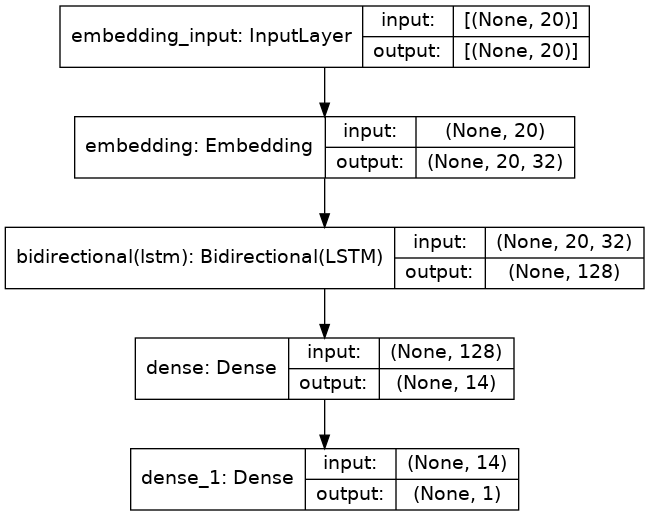

In [45]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

## Treinando o modelo

In [46]:
import time
start_time = time.time()

num_epochs = 10
history = model.fit(training_padded, y_train, epochs=num_epochs, validation_data=(valid_padded, y_valid))

final_time = (time.time()- start_time)/60
print(f'The time in minutos: {final_time}')

Epoch 1/10
119/119 [==============================] - 8s 35ms/step - loss: 0.6709 - accuracy: 0.5721 - val_loss: 0.5168 - val_accuracy: 0.7496
Epoch 2/10
119/119 [==============================] - 3s 24ms/step - loss: 0.3284 - accuracy: 0.8680 - val_loss: 0.6022 - val_accuracy: 0.7580
Epoch 3/10
119/119 [==============================] - 3s 26ms/step - loss: 0.1453 - accuracy: 0.9547 - val_loss: 0.6823 - val_accuracy: 0.7604
Epoch 4/10
119/119 [==============================] - 3s 25ms/step - loss: 0.0755 - accuracy: 0.9772 - val_loss: 0.6022 - val_accuracy: 0.7533
Epoch 5/10
119/119 [==============================] - 3s 25ms/step - loss: 0.0603 - accuracy: 0.9848 - val_loss: 0.8304 - val_accuracy: 0.7580
Epoch 6/10
119/119 [==============================] - 3s 24ms/step - loss: 0.0431 - accuracy: 0.9876 - val_loss: 0.7386 - val_accuracy: 0.7417
Epoch 7/10
119/119 [==============================] - 3s 24ms/step - loss: 0.0448 - accuracy: 0.9880 - val_loss: 0.8640 - val_accuracy: 0.7509

In [47]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.625784,0.645653,0.516809,0.749606
1,0.329095,0.866562,0.602190,0.758014
2,0.143279,0.954032,0.682344,0.760378
3,0.086854,0.975834,0.602234,0.753284
4,0.070521,0.980037,0.830418,0.758014


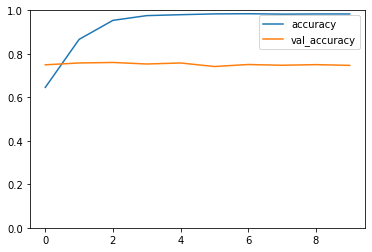

In [48]:
# verificando no gráfico o desempenho do modelo
model_loss[['accuracy','val_accuracy']].plot(ylim=[0,1]);

## Validando o modelo

In [49]:
#predictions = model.predict_classes(valid_padded)   # predict_ clases because is classification problem with the split test
predictions = np.argmax(model.predict(valid_padded), axis=-1)

In [50]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

## Matriz de confusão

In [51]:
# matriz de confusão
def plot_cm(y_true, y_pred, title, figsize=(5,4)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Atual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

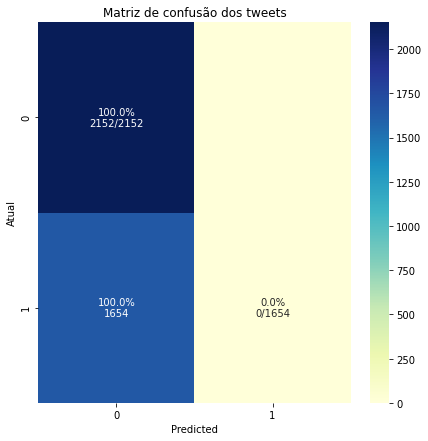

In [52]:
# plotando o gráfico
plot_cm(y_valid, predictions, 'Matriz de confusão dos tweets', figsize=(7,7))

# Conjunto de dados do test

In [53]:
testing_sequences1 = tokenizer.texts_to_sequences(test.clean_text)
testing_padded1 = pad_sequences(testing_sequences1, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [54]:
predictions = model.predict(testing_padded1)

# Submissão

In [55]:
submission =  pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [56]:
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [57]:
submission['target'] = (predictions > 0.5).astype(int)
submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,0
3260,10868,0
3261,10874,1


In [58]:
submission.to_csv('submission.csv', index=False, header=True)